In [239]:
#!pip install yellowbrick
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from yellowbrick.cluster import KElbowVisualizer
from tqdm import tqdm
from datetime import timedelta
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

Supprimons les ordres de moins de 30 jours.

In [267]:
customers = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_customers_dataset.csv')
geolocalisation = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_geolocation_dataset.csv')
order_items = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_order_items_dataset.csv')
order_payments = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_order_reviews_dataset.csv')
orders = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_orders_dataset.csv')
products = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_products_dataset.csv')
sellers = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\olist_sellers_dataset.csv')
translation = pd.read_csv('C:\\Users\\Nordine\\Documents\\Projet5-Openclassrooms-master\\Projet5-Openclassrooms-master\\product_category_name_translation.csv')


In [278]:




dict_categories = {
#maison (meubles et deco)
'furniture_living_room' : 'home',
'furniture_mattress_and_upholstery' : 'home',
'furniture_bedroom' : 'home',
'furniture_decor' : 'home',
'bed_bath_table' : 'home',
'kitchen_dining_laundry_garden_furniture' : 'home',
'la_cuisine' : 'home',
'home_confort' : 'home',
'home_comfort_2' : 'home',
'christmas_supplies' : 'home',
    
#articles ménagers 
'small_appliances' : 'appliances',
'small_appliances_home_oven_and_coffee' : 'appliances',
'home_appliances_2' : 'appliances',
'home_appliances' : 'appliances',
'housewares' : 'appliances',
    
#maison / bricolage
'construction_tools_construction': 'construction',
'costruction_tools_garden': 'construction',
'costruction_tools_tools': 'construction',
'construction_tools_safety': 'construction',
'construction_tools_lights': 'construction',
'home_construction': 'construction',
'air_conditioning': 'construction',
    
#bureau 
'office_furniture' : 'office',
'industry_commerce_and_business' : 'office',
'stationery' : 'office',
'agro_industry_and_commerce' : 'office',
'signaling_and_security' : 'office',
'furnitures' : 'office',
'security_and_services' : 'office',
    
#electronique
'telephony' : 'electronics',
'electronics': 'electronics',
'computers_accessories': 'electronics',
'consoles_games': 'electronics',
'fixed_telephony': 'electronics',
'audio': 'electronics',
'computers': 'electronics',
'tablets_printing_image': 'electronics',
    
# loisirs sportif
'sports_leisure' : 'sports_leisure',
'musical_instruments': 'sports_leisure',
'party_supplies': 'sports_leisure',
'luggage_accessories': 'sports_leisure',
    
# culture
'books' : 'arts',
'books_imported': 'arts',
'books_general_interest': 'arts',
'books_technical': 'arts',
'art': 'arts',
'toys': 'arts',
'cine_photo': 'arts',
'cds_dvds_musicals': 'arts',
'music': 'arts',
'dvds_blu_ray': 'arts',
'arts_and_craftmanship': 'arts',
    
# mode
'watches_gifts' : 'fashion',
'fashion_bags_accessories' : 'fashion',
'fashion_underwear_beach' : 'fashion',
'fashion_shoes' : 'fashion', 
'fashion_male_clothing' : 'fashion',
'fashio_female_clothing' : 'fashion',
'fashion_sport' : 'fashion',
'fashion_childrens_clothes' : 'fashion',
    
# parapharmacie
'health_beauty' : 'health_beauty', 
'baby': 'health_beauty',
'diapers_and_hygiene' : 'health_beauty',
'perfumery' : 'health_beauty',
    
#jardin/fleurs
'flowers' : 'garden',
'garden_tools' : 'garden',
    
# animaux domestiques
'pet_shop' : 'pets',
#auto 
'auto' : 'auto',
    
# alimentation
'food_drink' : 'food_drinks',
'food' : 'food_drinks',
'drinks' : 'food_drinks',
    
# indeterminé
'Unknown' : 'other',
'market_place' : 'other', 
'cool_stuff' : 'other'}

def r_score(x, quintiles):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c, quintiles):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5  

def redefine_date(orders, order_items):
    order_items['shipping_limit_date'] = order_items[
        'shipping_limit_date'].astype('datetime64')
    orders['order_purchase_timestamp'] = orders[
        'order_purchase_timestamp'].astype('datetime64')
    orders['order_approved_at'] = pd.to_datetime(orders[
        'order_approved_at'], errors='coerce')
    orders['order_delivered_carrier_date'] = pd.to_datetime(
        orders['order_delivered_carrier_date'], errors='coerce')
    orders['order_delivered_customer_date'] = pd.to_datetime(
        orders['order_delivered_customer_date'], errors='coerce')
    orders['order_estimated_delivery_date'] = orders[
        'order_estimated_delivery_date'].astype('datetime64')
    return orders, order_items
    
def categorize_datas(liste_df):
    for df, name in liste_df:
        for column in df.columns:              
            if df[column].nunique() < 50:
                df[column] = df[column].astype('category')
                
def feature_selection(customers, order_items, order_payments, order_reviews, orders, products, sellers):               
    customers = customers[['customer_state','customer_id', 'customer_unique_id']]    
    #order_payments.drop(columns=['payment_sequential', 'payment_installments'], inplace=True)
    order_reviews = order_reviews[['order_id', 'review_score']]
    orders = orders[['order_id', 'customer_id', 'order_delivered_customer_date', 'order_purchase_timestamp']]
    products = pd.merge(products, translation)[['product_id', 'product_category_name_english']]
    sellers = sellers[['seller_id', 'seller_state']]
    return customers, order_items, order_payments, order_reviews, orders, products, sellers


                
def clean_data(customers, geolocalisation, order_items, order_payments, order_reviews, orders, products, sellers, translation, d):
    redefine_date(orders, order_items)
    liste_df = [(customers, 'customers'), 
            (geolocalisation, 'geolocalisation'),
            (order_items, 'order_items'),
            (order_payments, 'order_payments'),
           (order_reviews, 'order_reviews'),
            (orders, 'orders'),
             (products, 'products'),
            (sellers, 'sellers'),
            (translation, 'translation')]
    categorize_datas(liste_df)
    geolocalisation = geolocalisation.drop_duplicates()
    customers, order_items, order_payments, order_reviews, orders, products, sellers = \
    feature_selection(customers, order_items, order_payments, order_reviews, orders, products, sellers)  
    ordersWithCustomers = pd.merge(orders, customers)
    NOW = orders['order_purchase_timestamp'].max() + timedelta(days=1)
    
    #############################################################################
    MAX_MOINS_DJ = orders['order_purchase_timestamp'].max() - timedelta(days=d)
    orders = orders[orders['order_purchase_timestamp'] < MAX_MOINS_DJ]
    #############################################################################
    
    ordersWithCustomers['DaysSinceOrder'] = ordersWithCustomers['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
    aggr = {
        'DaysSinceOrder': lambda x: x.min(),  # the number of days since last order (Recency)
        'order_purchase_timestamp': lambda x: len([d for d in x if d >= NOW - timedelta(days=720)]), # the total number of orders in the last period (Frequency)
    }
    rfm = ordersWithCustomers.groupby('customer_unique_id').agg(aggr).reset_index()
    totAchatParClient = pd.merge(customers, pd.merge(order_items, orders[orders['order_purchase_timestamp'] > NOW - timedelta(days=365)])).groupby('customer_unique_id').sum().reset_index()[['customer_unique_id', 'price']]
    rfm = rfm.merge(totAchatParClient)
    rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_purchase_timestamp': 'Frequency', 'price' : 'Monetary'}, inplace=True)
    
    ordersWithCustomersWithPrices = pd.merge(ordersWithCustomers, order_items)
    
    tqdm.pandas()   
  
    rfm['Monetary'] = np.log2(1 + rfm['Monetary'])
    totAchatParClient = pd.merge(customers, pd.merge(order_items, orders)).groupby('customer_unique_id').sum().reset_index()[['customer_unique_id', 'price']]
    produitsParClient = pd.merge(customers, pd.merge(orders, pd.merge(order_items, products)))
    produitsPlusAchetee = produitsParClient.groupby('customer_unique_id')['product_category_name_english'].agg(lambda x:x.value_counts().index[0]).reset_index(name='categorie')
    nbreProdParClients = pd.merge(customers, pd.merge(orders, order_items)).groupby('customer_unique_id')['product_id'].count().reset_index(name='nbProds')
    order_reviews['review_score'] = order_reviews['review_score'].astype('int32')
    score_moy = pd.merge(customers, pd.merge(orders, order_reviews)).groupby('customer_unique_id')['review_score'].mean().reset_index(name='score_moy')
    delai_delivery = pd.merge(orders, order_items)
    delai_delivery['Delai_livraison_Commande'] = delai_delivery['order_delivered_customer_date'] - delai_delivery[
       'order_purchase_timestamp']
    delai_delivery['Delai_livraison_Commande'] = delai_delivery['Delai_livraison_Commande'].dt.days
    delai_delivery['Delai_livraison_Commande'].fillna(-1, inplace=True)
    delai_delivery = pd.merge(customers[['customer_id', 'customer_unique_id']], delai_delivery[['customer_id', 'Delai_livraison_Commande' ]]).groupby('customer_unique_id').mean().reset_index()
    data = pd.merge(nbreProdParClients, produitsPlusAchetee).merge(delai_delivery).merge(score_moy)
    data = pd.merge(data, rfm)
    data['categorie'] = data['categorie'].map(dict_categories)
    data['categorie'] = data['categorie'].astype('category')
    
    #data['nbProds'] = data.apply(categorise_nbProds, axis=1)
    #data['nbProds'] =  data['nbProds'].astype('category')    
    data['score_moy'] =  data['score_moy'].astype('category')
    #data['price'] = np.log2(1 + data['price'])
    return data.drop(columns=['Frequency', 'nbProds'])

    
#data['customer_unique_id'].duplicated().sum()

Vérifions la qualité des clusters:

In [287]:
def getModel(d):
    
    dataset0 = clean_data(customers, geolocalisation, order_items,
                         order_payments, order_reviews, orders, products, sellers, translation, 0)
    
    dataset1 = clean_data(customers, geolocalisation, order_items,
                         order_payments, order_reviews, orders, products, sellers, translation, d)
    dataset0 = dataset0[dataset0['customer_unique_id'].isin(dataset1['customer_unique_id'])]
    
   
    dataset0.set_index('customer_unique_id', inplace=True)
    dataset0['score_moy'] = dataset0['score_moy'].astype('float64')
    
    dataset1.set_index('customer_unique_id', inplace=True)
    dataset1['score_moy'] = dataset1['score_moy'].astype('float64')
    
    X_data0 = dataset0.copy()
    
    X_data1 = dataset1.copy()
    
    categorical_columns = X_data0.select_dtypes(['category','object']).columns
    numerical_columns = X_data0.select_dtypes(['int32', 'int64','float64']).columns
    
   
    ohe = OneHotEncoder(sparse=False)
    ss = StandardScaler()
    
    X_data0[numerical_columns] = ss.fit_transform(X_data0[numerical_columns])
    ohe.fit(X_data0[categorical_columns])
    X_data0 = pd.merge(X_data0[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X_data0[categorical_columns])).set_index(X_data0.index),
        left_index = True, right_index = True) 
    
    X_data1[numerical_columns] = ss.fit_transform(X_data1[numerical_columns])
    ohe.fit(X_data1[categorical_columns])
    X_data1 = pd.merge(X_data1[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X_data1[categorical_columns])).set_index(X_data1.index),
        left_index = True, right_index = True)
    
    pca0 = PCA(random_state=1, n_components=6)
    pca0.fit(X_data0)
    X_pca0 =pca0.transform(X_data0) 
    
    pca1 = PCA(random_state=1, n_components=6)
    pca1.fit(X_data1)
    X_pca1 =pca1.transform(X_data1)
    
    kmeans_pca0 = KMeans(n_clusters = 4, init ='k-means++', random_state = 42, n_init=25, max_iter=200)
    kmeans_pca0.fit(X_pca0)
    
    kmeans_pca1 = KMeans(n_clusters = 4, init ='k-means++', random_state = 42, n_init=25, max_iter=200)
    kmeans_pca1.fit(X_pca1)
    
    return kmeans_pca0.labels_, kmeans_pca1.labels_

def getAdjustedScore(M0, M1):
   
    return adjusted_rand_score(M0, M1)



def compareModels():   
    scoresDict = {}
    for i in tqdm(np.arange(20,105,5).tolist()):
        M0, M = getModel(i)       
        scoresDict[i] = getAdjustedScore(M0, M)
    return scoresDict

scoresDict = compareModels()

scoresDict
    

100%|██████████| 17/17 [44:04<00:00, 155.55s/it]


{20: 1.0,
 25: 1.0,
 30: 1.0,
 35: 1.0,
 40: 1.0,
 45: 0.999830414779547,
 50: 0.9581173683415012,
 55: 0.9883867039654336,
 60: 0.9969594537212197,
 65: 0.9835438458567999,
 70: 0.993407000628795,
 75: 0.9794051601875988,
 80: 0.9810295565634772,
 85: 0.9876604848571985,
 90: 0.9762555099843916,
 95: 0.9824300226289664,
 100: 0.9921404632363505}

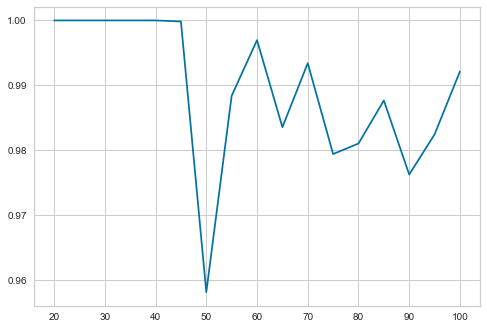

In [293]:
plt.plot(scoresDict.keys(), scoresDict.values())

### Conclusion

On constate qu'à partir de 50 jours, certains clients changent de segments. Il est donc préférable de relancer à ce moment là la segmentation.